# GAN Pseudotime latent space interpolation

In [1]:
import numpy as np
import tensorflow as tf
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Load data

In [2]:
from numpy import genfromtxt
#kasper_rank_matrix = genfromtxt('kasper_data_rank_normalised_top784_norownames.csv', delimiter=',', skip_header=1)
#kasper_rank_matrix = genfromtxt('kasper_data_raw_top784_v2.csv', delimiter=',', skip_header=1)

kasper_rank_matrix = genfromtxt('kasper_data_raw_full.csv', delimiter=',', skip_header=1)

#only use first 1000 cells
kasper_rank_matrix_unwitheld = kasper_rank_matrix
kasper_rank_matrix = kasper_rank_matrix[:,0:1000]

print(kasper_rank_matrix.shape)

import matplotlib.pyplot as plt
kasper_unprocessed_hst = np.hstack(kasper_rank_matrix)


(6707, 1000)


### Parameters

In [3]:
n_train_steps = 30
batch_size = 256 #originally 128

noise_input_size = 100
inflate_to_size = 600
gex_size = 6707

disc_internal_size = 200

### Generator

In [4]:
def lrelu(x):
    return tf.maximum(x, 0.2 * x)

z = tf.placeholder(tf.float32, shape=(None, noise_input_size))
g_w1 = tf.get_variable("g_w1", [noise_input_size,inflate_to_size], initializer=tf.random_uniform_initializer(-0.05, 0.05),
                      regularizer=tf.contrib.layers.l2_regularizer(0.8))
g_b1 = tf.get_variable("g_b1", [inflate_to_size], initializer=tf.constant_initializer(0.1))
g_w2 = tf.get_variable("g_w2", [inflate_to_size,inflate_to_size], initializer=tf.random_uniform_initializer(-0.05, 0.05),
                       regularizer=tf.contrib.layers.l2_regularizer(0.8))
g_b2 = tf.get_variable("g_b2", [inflate_to_size], initializer=tf.constant_initializer(0.1))
g_w3 = tf.get_variable("g_w3", [inflate_to_size, gex_size], initializer=tf.random_uniform_initializer(-0.05, 0.05),
                       regularizer=tf.contrib.layers.l2_regularizer(0.8))
g_b3 = tf.get_variable("g_b3", [gex_size], initializer=tf.constant_initializer(0.1))

g_params = [g_w1, g_b1, g_w2, g_b2, g_w3, g_b3]

def generator(z):
    g_y1 = lrelu(tf.matmul(z, g_w1) + g_b1)
    g_y2 = lrelu(tf.matmul(g_y1, g_w2) + g_b2)
    G = tf.nn.relu(tf.matmul(g_y2, g_w3) + g_b3)
    
    #tensorboard
    tf.summary.histogram('layer1/g_y1', g_y1)
    tf.summary.histogram('layer2/g_y2', g_y2)
    tf.summary.histogram('layer3/out', G)
    
    return G

With the `noise_prior`, the choices to explore are the distribution used to generate the noise and the parameters of that distribution. The two obvious choices are the normal and uniform distribution. It seemed like a standard normal was a little more consistent in getting reasonable results.

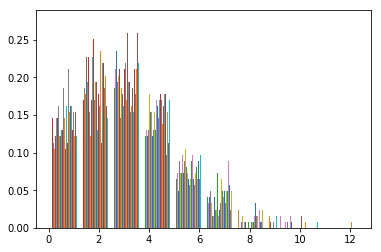

In [5]:
#changed so that max value in noise generation prior is max value of data

import numpy as np
import matplotlib.pyplot as plt

data_max_value = numpy.amax(kasper_rank_matrix)

def noise_prior(batch_size, dim):
    temp_norm = np.random.normal(0.0, data_max_value/10, size=(batch_size, dim))
    temp_poisson = np.random.poisson(1, size=(batch_size, dim))
    return np.abs(temp_norm + temp_poisson)

def noise_prior_special(batch_size, dim, data_max_value, poiss):
    temp_norm = np.random.normal(0.0, data_max_value/10, size=(batch_size, dim))
    temp_poisson = np.random.poisson(poiss, size=(batch_size, dim))
    return np.abs(temp_norm + temp_poisson)

test = noise_prior_special(100,100, data_max_value, 3)
count, bins, ignored = plt.hist(test, normed=True)
plt.show()



### The Discriminator

In [6]:
x = tf.placeholder(tf.float32, shape=(None, gex_size))
d_w1 = tf.get_variable("d_w1", [gex_size,disc_internal_size], initializer=tf.random_uniform_initializer(-0.005, 0.005),
                       regularizer=tf.contrib.layers.l2_regularizer(0.8))
d_b1 = tf.get_variable("d_b1", [disc_internal_size], initializer=tf.constant_initializer(0.1))
d_w2 = tf.get_variable("d_w2", [disc_internal_size,disc_internal_size], initializer=tf.random_uniform_initializer(-0.005,0.005),
                       regularizer=tf.contrib.layers.l2_regularizer(0.8))
d_b2 = tf.get_variable("d_b2", [disc_internal_size], initializer=tf.constant_initializer(0.1))
d_w3 = tf.get_variable("d_w3", [disc_internal_size,1], initializer=tf.random_uniform_initializer(-0.005,0.005),
                       regularizer=tf.contrib.layers.l2_regularizer(0.8))
d_b3 = tf.get_variable("d_b3", [1], initializer=tf.constant_initializer(0.1))

d_params = [d_w1, d_b1, d_w2, d_b2, d_w3, d_b3]

#d_weights = [d_w1, d_w2, d_w3]

clip_d = None

def discriminator(x):
    d_y1 = lrelu(tf.matmul(x, d_w1) + d_b1)
    d_y2 = lrelu(tf.matmul(d_y1, d_w2) + d_b2)
    D = tf.matmul(d_y2, d_w3) + d_b3

    weights_d1 = tf.summary.histogram('d_layer1/d_w1', d_w1)
    weights_d2 = tf.summary.histogram('d_layer2/d_w2', d_w2)
    weights_d3 = tf.summary.histogram('d_layer3/d_w3', d_w3)

    bias_d1 = tf.summary.histogram('d_layer1/d_b1', d_b1)
    bias_d2 = tf.summary.histogram('d_layer2/d_b2', d_b2)
    bias_d3 = tf.summary.histogram('d_layer3/d_b3', d_b3)

    tf.summary.histogram('d_layer1/d_y1', d_y1)
    tf.summary.histogram('d_layer2/d_y2', d_y2)
    tf.summary.histogram('d_layer3/D', D)
    
    return D



Define the outputs we're going to train.

In [7]:
G = generator(z)
D_real = discriminator(x)
D_fake = discriminator(G)

### The Training Objectives

Changed for Wasserstein distance/objectives

In [8]:
print(D_real.shape)

(?, 1)


In [9]:
LAMBDA = 10 # Gradient penalty lambda hyperparameter

obj_d = tf.reduce_mean(D_fake) - tf.reduce_mean(D_real)
obj_g = -tf.reduce_mean(D_fake)

##### need to expand shape of alpha?

alpha = tf.random_uniform(
    shape=[batch_size,gex_size], 
    minval=0.,
    maxval=1.
)

differences = D_fake - D_real
interpolates = D_real + (alpha*differences)
gradients = tf.gradients(discriminator(interpolates), [interpolates])[0]
slopes = tf.sqrt(tf.reduce_sum(tf.square(gradients), reduction_indices=[1]))
gradient_penalty = tf.reduce_mean((slopes-1.)**2)
obj_d += LAMBDA*gradient_penalty

In [10]:
def exp_decay(initial_rate, step, decay_factor, min_lr):
    return tf.maximum(initial_rate / tf.pow(decay_factor, tf.to_float(step)), min_lr)

def momentum_adjustor(initial_momentum, step, final_momentum, saturation_point):
    m = initial_momentum + (final_momentum - initial_momentum) * (tf.to_float(step) / saturation_point)
    return tf.minimum(m, final_momentum)

time_step = tf.placeholder(tf.int32)

d_batch = tf.Variable(0, trainable=False)
d_learning_rate = exp_decay(0.01, time_step, 1.000004, 0.000001)
d_momentum = momentum_adjustor(0.5, d_batch, 0.7, 250)
#opt_d = tf.train.MomentumOptimizer(d_learning_rate, d_momentum).minimize(obj_d, var_list=d_params, global_step=d_batch)
opt_d = tf.train.RMSPropOptimizer(learning_rate=5e-5).minimize(obj_d, var_list=d_params)

g_batch = tf.Variable(0, trainable=False)
g_learning_rate = exp_decay(0.01, time_step, 1.000004, 0.000001)
g_momentum = momentum_adjustor(0.5, g_batch, 0.7, 250)
#opt_g = tf.train.MomentumOptimizer(g_learning_rate, g_momentum).minimize(obj_g, var_list=g_params, global_step=g_batch)
opt_g = tf.train.RMSPropOptimizer(learning_rate=5e-5).minimize(obj_g, var_list=g_params)

d_momentum_summary = tf.summary.scalar('d_momentum', d_momentum)
g_momentum_summary = tf.summary.scalar('g_momentum', g_momentum)
d_learning_rate_summary = tf.summary.scalar('d_learning_rate', d_learning_rate)
g_learning_rate_summary = tf.summary.scalar('g_learning_rate', g_learning_rate)
obj_d_summary = tf.summary.scalar('obj_d', obj_d)
obj_g_summary = tf.summary.scalar('obj_g', obj_g)

#with tf.name_scope("layer1"):
#    weights_g1 = tf.summary.histogram('g_w1', g_w1)
#    bias_g1 = tf.summary.histogram('g_b1', g_b1)
#    layer1 = tf.matmul(z,g_w1)

weights_g1 = tf.summary.histogram('layer1/g_w1', g_w1)
weights_g2 = tf.summary.histogram('layer2/g_w2', g_w2)
weights_g3 = tf.summary.histogram('layer3/g_w3', g_w3)

bias_g1 = tf.summary.histogram('layer1/g_b1', g_b1)
bias_g2 = tf.summary.histogram('layer2/g_b2', g_b2)
bias_g3 = tf.summary.histogram('layer3/g_b3', g_b3)


In [11]:
checkpoint_path = "./models/SN-WGAN-GP_v3.ckpt"

sess=tf.InteractiveSession()

merged = tf.summary.merge_all()

train_writer = tf.summary.FileWriter("./summaries/gan_full_set_v8", sess.graph)

saver = tf.train.Saver(max_to_keep=50)

tf.global_variables_initializer().run()

saver.restore(sess, checkpoint_path)

INFO:tensorflow:Restoring parameters from ./models/SN-WGAN-GP_v3.ckpt


In [12]:
print(kasper_rank_matrix.shape)

def generate_until_high_corr(cell, threshold, max_attempts):
    temp_corr = 0
    
    max_corr = 0
    max_corr_z = 0
    
    num_attempts = 0
    while temp_corr < threshold and num_attempts < max_attempts:
        rand_z = noise_prior_special(1,100, data_max_value, 1)
        temp_gen = sess.run(G, {z : rand_z })
        temp_corr = np.corrcoef(temp_gen, cell)
        temp_corr = np.min(temp_corr)
        num_attempts = num_attempts + 1
        if temp_corr > max_corr:
            max_corr = temp_corr
            max_corr_z = rand_z
        if (num_attempts % 1000) == 0:
            print("Generated cells: " + str(num_attempts) + " Max corr.: " + str(max_corr))
    return max_corr, max_corr_z

max_corr, max_corr_z = generate_until_high_corr(kasper_rank_matrix[:,11], threshold=0.84, max_attempts=10000)

print(max_corr_z)    
        

(6707, 1000)
Generated cells: 1000 Max corr.: 0.690163248348
Generated cells: 2000 Max corr.: 0.693177862661
Generated cells: 3000 Max corr.: 0.693177862661
Generated cells: 4000 Max corr.: 0.695095244955
Generated cells: 5000 Max corr.: 0.695095244955
Generated cells: 6000 Max corr.: 0.695095244955
Generated cells: 7000 Max corr.: 0.695095244955
Generated cells: 8000 Max corr.: 0.695095244955
Generated cells: 9000 Max corr.: 0.695095244955
Generated cells: 10000 Max corr.: 0.695095244955
[[ 2.67404553  0.97535727  0.1407342   2.35402388  0.06279543  2.43173045
   2.08093713  1.10438416  0.27408514  0.16011636  0.7126976   1.42193689
   1.84664029  0.56886451  3.10162661  1.20580612  0.02303769  1.62942038
   0.68325562  3.4137321   0.28053458  0.09312997  0.43492087  1.71711168
   1.46160431  2.67106832  0.90365806  0.01041444  1.98952695  3.12520285
   2.19287911  0.09795288  2.03020741  2.84613592  0.45036683  0.44805576
   2.88339839  0.41270804  0.25143673  0.76898024  1.52180761 

### Generate cells from a checkpoint

In [13]:
def interpolate_two_cell_z(z_a, z_b, num_points):
    z_diff = z_b - z_a
    z_diff = numpy.true_divide(z_diff, num_points)

    z_output = z_a
    for step in range(1,num_points):
        z_step = z_a + step*z_diff
        z_output = numpy.append(z_output, z_step, axis=0)
        
    return z_output

z_test_a = noise_prior(1, 100)
z_test_b = noise_prior(1, 100)

interpolation_zab = interpolate_two_cell_z(z_test_a, z_test_b, 1000)
print(interpolation_zab.shape)
print(interpolation_zab[:,1].shape)

interp_gen = sess.run(G, {z : interpolation_zab })
print(interp_gen.shape)


(1000, 100)
(1000,)
(1000, 6707)


### Pick cells; generate LSI; generate gene expression

In [19]:
import csv
with open("./kasper_celltype_labels.txt", "rb") as f:
    reader = csv.reader(f, delimiter='\t')
    cell_type_labels = reader.next()

is_basal = ["IFE-B" in i for i in cell_type_labels]
is_d1 = ["IFE-DI" in i for i in cell_type_labels]
is_d2 = ["IFE-DII" in i for i in cell_type_labels]


basal_idx = [i for i, x in enumerate(is_basal) if x]
d1_idx = [i for i, x in enumerate(is_d1) if x]
d2_idx = [i for i, x in enumerate(is_d2) if x]

basal_example = [i for i, x in enumerate(is_basal) if x][0]
d1_example = [i for i, x in enumerate(is_d1) if x][0]
d2_example = [i for i, x in enumerate(is_d2) if x][0]

#print(basal_example)
#print(d1_example)
#print(d2_example)

#max_corr_basal, max_corr_z_basal = generate_until_high_corr(kasper_rank_matrix[:,basal_example], threshold=0.8, max_attempts=10000)
#max_corr_d1, max_corr_z_d1 = generate_until_high_corr(kasper_rank_matrix[:,d1_example], threshold=0.8, max_attempts=10000)
#max_corr_d2, max_corr_z_d2 = generate_until_high_corr(kasper_rank_matrix[:,d2_example], threshold=0.8, max_attempts=10000)

#interpolation_basal_d1 = interpolate_two_cell_z(max_corr_z_basal, max_corr_z_d1, 1000)
#interpolation_d1_d2 = interpolate_two_cell_z(max_corr_z_d1, max_corr_z_d2, 1000)


330


In [27]:
#Function takes three states; 
#random sampling of cells ~100
#Take median express; lookup gene in fn later

#### NB improvement to be made: at the moment we are doing two different interpolations _/
#### improve by fitting a spline or some other smooth fit in 100D space between the points
#### should lead to a better and smoother prediction

num_rand_samples = 10

smoothed_pseudotransition_gex = 0
has_been_init = False
for rand_sample in range(0,num_rand_samples):
    print(rand_sample)
    basal_example = np.random.randint(len(basal_idx))
    d1_example = np.random.randint(len(d1_idx))
    d2_example = np.random.randint(len(d2_idx))
    
    max_corr_basal, max_corr_z_basal = generate_until_high_corr(kasper_rank_matrix[:,basal_example], threshold=0.75, max_attempts=2000)
    max_corr_d1, max_corr_z_d1 = generate_until_high_corr(kasper_rank_matrix[:,d1_example], threshold=0.75, max_attempts=2000)
    max_corr_d2, max_corr_z_d2 = generate_until_high_corr(kasper_rank_matrix[:,d2_example], threshold=0.75, max_attempts=2000)

    interpolation_basal_d1 = interpolate_two_cell_z(max_corr_z_basal, max_corr_z_d1, 1000)
    interpolation_d1_d2 = interpolate_two_cell_z(max_corr_z_d1, max_corr_z_d2, 1000)

    pseudotransition_z = np.concatenate((interpolation_basal_d1, interpolation_d1_d2), axis=0)

    pseudotransition_gex = sess.run(G, {z : pseudotransition_z })

    if has_been_init == False:
        smoothed_pseudotransition_gex = sess.run(G, {z : pseudotransition_z })
        has_been_init = True
    else:
        smoothed_pseudotransition_gex = np.add(smoothed_pseudotransition_gex,pseudotransition_gex)
        smoothed_pseudotransition_gex = np.divide(smoothed_pseudotransition_gex, 2)


0
Generated cells: 1000 Max corr.: 0.746413777045
Generated cells: 2000 Max corr.: 0.747722041038
Generated cells: 1000 Max corr.: 0.667954481677
Generated cells: 2000 Max corr.: 0.668410980065
1
Generated cells: 1000 Max corr.: 0.692263327651
Generated cells: 2000 Max corr.: 0.696968689952
Generated cells: 1000 Max corr.: 0.71455342038
Generated cells: 2000 Max corr.: 0.71455342038
Generated cells: 1000 Max corr.: 0.709431314402
Generated cells: 2000 Max corr.: 0.709431314402
2
Generated cells: 1000 Max corr.: 0.65309029723
Generated cells: 2000 Max corr.: 0.65309029723
3
Generated cells: 1000 Max corr.: 0.705162980503
Generated cells: 2000 Max corr.: 0.705854375365
Generated cells: 1000 Max corr.: 0.70219641663
Generated cells: 2000 Max corr.: 0.707595726711
Generated cells: 1000 Max corr.: 0.699748304528
Generated cells: 2000 Max corr.: 0.704680977435
4
Generated cells: 1000 Max corr.: 0.695146167119
Generated cells: 2000 Max corr.: 0.695146167119
5
6
Generated cells: 1000 Max corr.

In [28]:
#pseudotransition_z = np.concatenate((interpolation_basal_d1, interpolation_d1_d2), axis=0)

#pseudotransition_gex = sess.run(G, {z : pseudotransition_z })

print(smoothed_pseudotransition_gex.shape)

(2000, 6707)


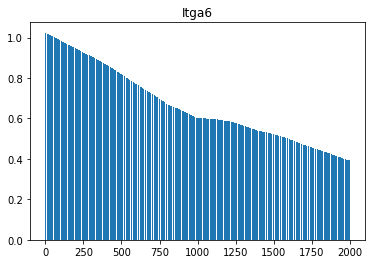

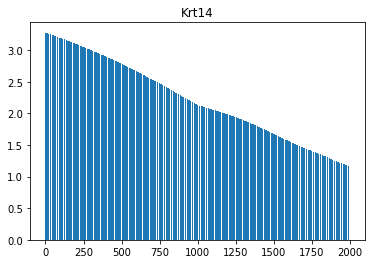

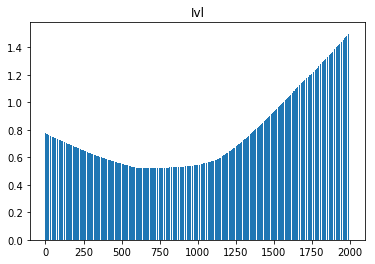

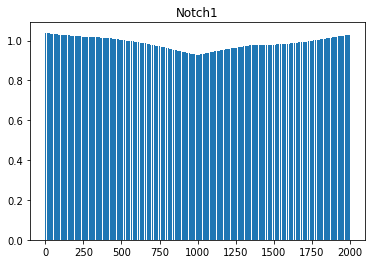

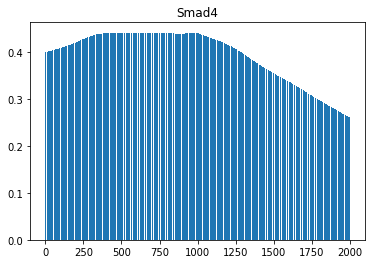

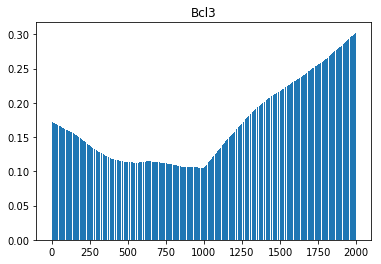

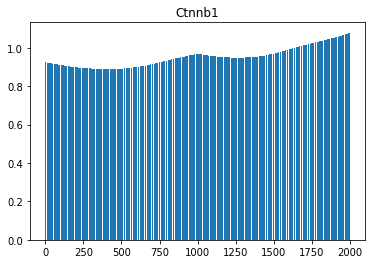

In [40]:
import csv
with open('kasper_data_rownames_full.csv', 'rb') as f:
    reader = csv.reader(f)
    genes = list(reader)

genes = numpy.array(genes)

def plot_gene_expression_time(time_gex, gene_name):
    gene_index = [i for i, x in enumerate(genes) if x == gene_name][0]
    plt.bar(np.arange(0,time_gex.shape[0],1), time_gex[:,gene_index])
    plt.title(gene_name)
    plt.show()
    
plot_gene_expression_time(smoothed_pseudotransition_gex, "Itga6")

plot_gene_expression_time(smoothed_pseudotransition_gex, "Krt14")

plot_gene_expression_time(smoothed_pseudotransition_gex, "Ivl")

plot_gene_expression_time(smoothed_pseudotransition_gex, "Notch1")

plot_gene_expression_time(smoothed_pseudotransition_gex, "Smad4")

plot_gene_expression_time(smoothed_pseudotransition_gex, "Bcl3")

plot_gene_expression_time(smoothed_pseudotransition_gex, "Ctnnb1")


In [ ]:
#interpolated z
plt.hist(pseudotransition_z, bins='auto', alpha=0.3, label='z_interp') # arguments are passed to np.histogram
plt.title("Distribution of interpolated z vectors")
pyplot.legend(loc='upper right')
savefig("z_interp_histogram.pdf")
plt.show()

In [ ]:
#Calc tSNE
from sklearn.manifold import TSNE
n_genes_cov = 500

X = pseudotransition_gex

data_cov = numpy.var(interp_gen, axis=1)/numpy.mean(interp_gen, axis=1)
data_cov_index_desc = data_cov.argsort()[::-1][:n_genes_cov]

X = X[:,data_cov_index_desc]

model = TSNE(n_components=2, random_state=0)
np.set_printoptions(suppress=True)
combined_tsne = model.fit_transform(X)

print(X.shape)


In [ ]:
#Plot tSNE
import matplotlib.cm as cm

print(combined_tsne.shape)

tsne_color = np.concatenate([np.repeat("red",1), np.repeat("black",998), np.repeat("green",1)])

plt.scatter(combined_tsne[:,0],combined_tsne[:,1], c=tsne_color)
plt.show()

In [ ]:
import seaborn as sns; sns.set()
print(X.shape)
g = sns.clustermap(np.log(1+np.transpose(X)), col_cluster=False, z_score=0)
